# Import necessary libraries

In [3]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds

# Downloading dataset

In [4]:
dataset , info = tfds.load("malaria" , as_supervised = True , with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.IDQVP1_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Read some information about dataset

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp0y5laqf1tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [10]:
dataset = dataset['train']

In [11]:
print(len(dataset))

27558


# Visualize our images

In [16]:
sample_images = []
sample_labels = []
count = 0
for image , label in dataset:
  if count == 25:
    break
  if count < 1:

    print(f"image shape : {image.shape}")
    print(f"label shape : {label.shape}")
  sample_images.append(image)
  sample_labels.append(label)
  count += 1

image shape : (103, 103, 3)
label shape : ()


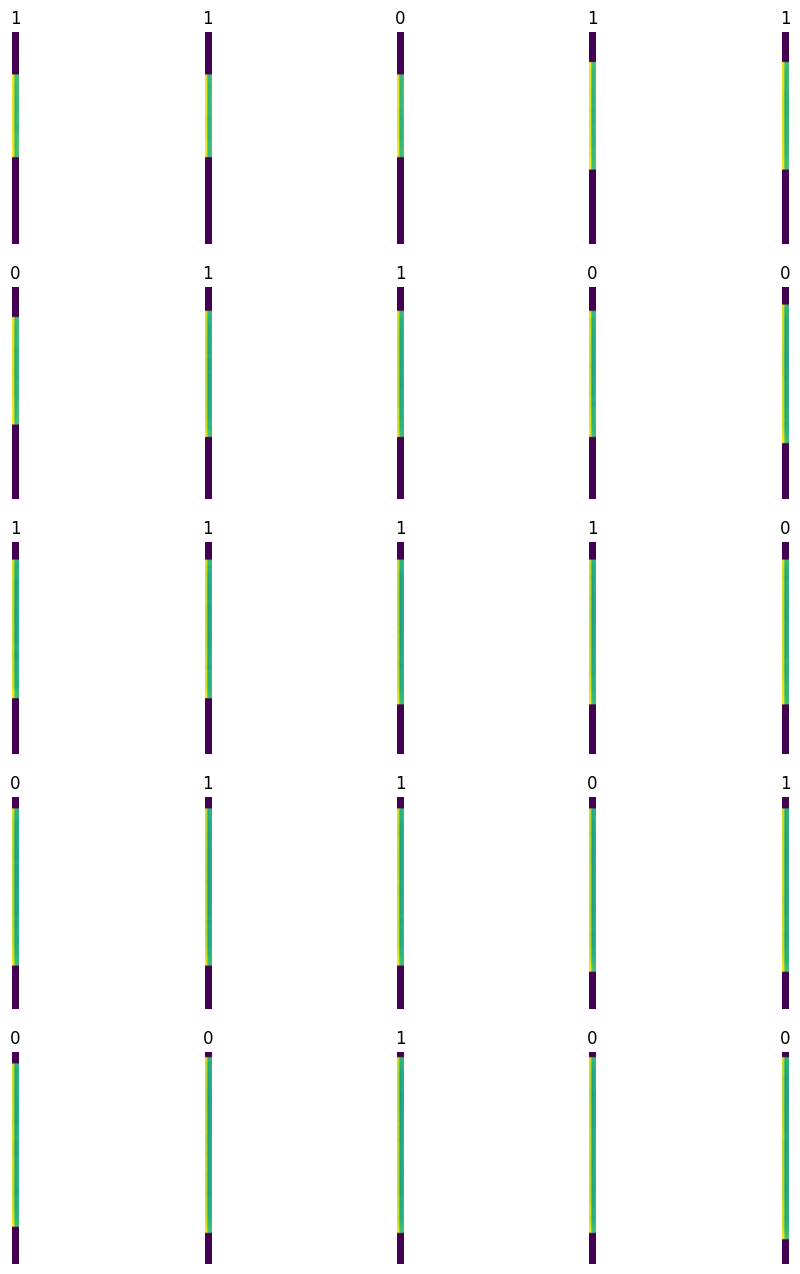

In [136]:
plt.figure(figsize = (12,16))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(sample_images[0][i].numpy())
  plt.title(sample_labels[i].numpy())
  plt.axis("off")
plt.show()

# Preprocess our images and labels

In [107]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (224,224))
    label = tf.one_hot(label, depth=2)
    return image, label

In [108]:
preprocessed_dataset = dataset.map(preprocess)

In [109]:
for image , label in preprocessed_dataset:
  print(f"image shape : {image.shape}")
  print(f"label shape : {label.shape}")
  break

image shape : (224, 224, 3)
label shape : (2,)


In [110]:
print(len(preprocessed_dataset))

27558


In [111]:
train_dataset = preprocessed_dataset.take(24000).batch(64)
test_dataset = preprocessed_dataset.skip(24000).batch(64)

In [112]:
print(len(train_dataset))
print(len(test_dataset))

375
56


In [113]:
for image,label in train_dataset:
  print(f"image shape : {image.shape}")
  print(f"label shape : {label.shape}")
  break

image shape : (64, 224, 224, 3)
label shape : (64, 2)


# Create ResNet neural networks

In [114]:
def residual_block(x , filters , downsample = False):
  stride = 2 if downsample else 1
  x_skip = x

  x = keras.layers.Conv2D(filters ,(3,3) , strides = stride , activation = "relu" , padding = "same")(x)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
  x = keras.layers.BatchNormalization()(x)

  if downsample:
    x_skip = keras.layers.Conv2D(filters , kernel_size = (1,1) , padding = "same" , strides = stride)(x_skip)
    x_skip = keras.layers.BatchNormalization()(x_skip)

  x = keras.layers.Add()([x , x_skip])
  x = keras.layers.Activation('relu')(x)

  return x

In [115]:
def ResNet34(input_shape = (224,224,3) , n = 2):
  inputs = keras.layers.Input(shape = input_shape)
  x = keras.layers.Conv2D(filters = 64 , kernel_size = (7,7) , strides = (2,2) , activation = "relu" , padding = "same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D((3,3) , strides = (2,2) , padding = "same")(x)

  x = residual_block(x , 64)
  x = residual_block(x , 64)
  x = residual_block(x , 64)

  x = residual_block(x , 128 , downsample = True)
  x = residual_block(x , 128)
  x = residual_block(x , 128)
  x = residual_block(x , 128)

  x = residual_block(x , 256 , downsample = True)
  x = residual_block(x , 256)
  x = residual_block(x , 256)
  x = residual_block(x , 256)
  x = residual_block(x , 256)
  x = residual_block(x , 256)

  x = residual_block(x , 512 , downsample = True)
  x = residual_block(x , 512)
  x = residual_block(x , 512)

  x = keras.layers.GlobalAveragePooling2D()(x)

  outputs = keras.layers.Dense(n , activation = "softmax")(x)

  model = keras.Model(inputs , outputs)

  return model

In [116]:
model = ResNet34()

In [117]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 112, 112, 64)   │            256 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 56, 56, 64)     │            256 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 56, 56, 64)     │            256 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
│                           │                        │                │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_23             │ (None, 56, 56, 64)     │              0 │ add_24[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ activation_23[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_68    │ (None, 56, 56, 64)     │            256 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_69    │ (None, 56, 56, 64)     │            256 │ conv2d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
│                      

 Total params: 21,311,234 (81.30 MB)

 Trainable params: 21,294,210 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

None


# Train our model

In [118]:
model.compile(loss = keras.losses.CategoricalCrossentropy() , metrics = ["accuracy"] , optimizer = keras.optimizers.Adam(learning_rate = 0.001))

In [119]:
early_stop = EarlyStopping(monitor = 'val_loss' , restore_best_weights = True , patience = 5)

In [120]:
hist = model.fit(train_dataset , epochs = 10 , verbose = 2 , validation_data = test_dataset , callbacks = [early_stop])

Epoch 1/10
375/375 - 206s - 549ms/step - accuracy: 0.8052 - loss: 0.4413 - val_accuracy: 0.6625 - val_loss: 1.5661
Epoch 2/10
375/375 - 157s - 418ms/step - accuracy: 0.9551 - loss: 0.1420 - val_accuracy: 0.9505 - val_loss: 0.1955
Epoch 3/10
375/375 - 211s - 564ms/step - accuracy: 0.9574 - loss: 0.1313 - val_accuracy: 0.9387 - val_loss: 0.2250
Epoch 4/10
375/375 - 157s - 420ms/step - accuracy: 0.9598 - loss: 0.1222 - val_accuracy: 0.9514 - val_loss: 0.1856
Epoch 5/10
375/375 - 202s - 538ms/step - accuracy: 0.9614 - loss: 0.1165 - val_accuracy: 0.9587 - val_loss: 0.1362
Epoch 6/10
375/375 - 157s - 418ms/step - accuracy: 0.9623 - loss: 0.1132 - val_accuracy: 0.9221 - val_loss: 0.2764
Epoch 7/10
375/375 - 219s - 584ms/step - accuracy: 0.9628 - loss: 0.1112 - val_accuracy: 0.9556 - val_loss: 0.1423
Epoch 8/10
375/375 - 184s - 492ms/step - accuracy: 0.9647 - loss: 0.1068 - val_accuracy: 0.9517 - val_loss: 0.1432
Epoch 9/10
375/375 - 156s - 416ms/step - accuracy: 0.9642 - loss: 0.1070 - val_a

In [123]:
model.evaluate(test_dataset)

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9554 - loss: 0.1611


[0.1362033635377884, 0.9586846828460693]

# Show our model's metircs and accuracy

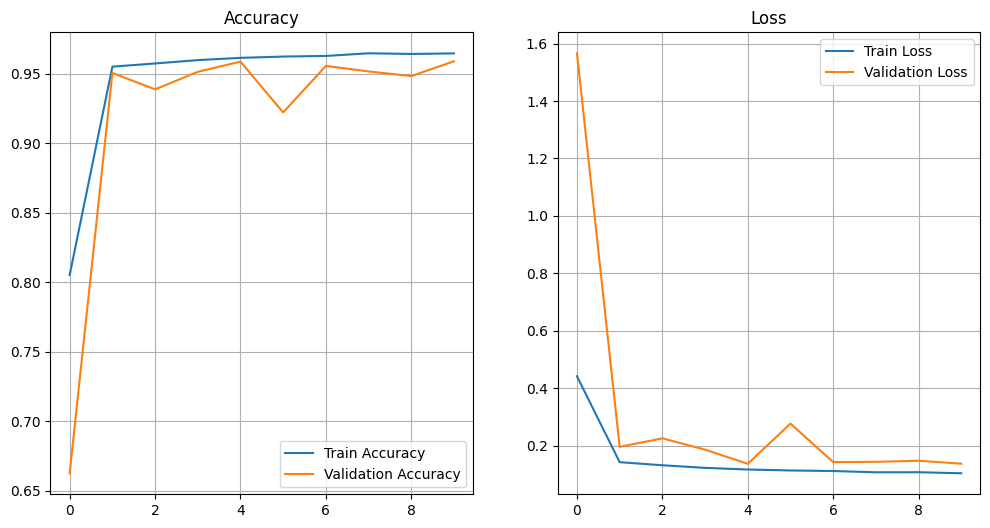

In [121]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'] , label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'] , label = "Validation Accuracy")
plt.axis()
plt.grid()
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'] , label = "Train Loss")
plt.plot(hist.history['val_loss'] , label = "Validation Loss")
plt.axis()
plt.grid()
plt.title("Loss")
plt.legend()

plt.show()

# Saves our model

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [125]:
path = '/conten/drive/MyDrice/MyModels/malariaacc95.h5'
model.save(path)

# Checking how our model works on testing dataset

In [126]:
sample_test_images = []
sample_test_labels = []
count = 0
for image , label in test_dataset.take(1):
  if count == 10:
    break
  sample_test_images.append(image)
  sample_test_labels.append(label)
  count += 1
predictions = model.predict(sample_test_images)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_196
Received: inputs=('Tensor(shape=(32, 224, 224, 3))',)
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


In [133]:
predicted_labels = [np.argmax(i) for i in predictions]
real_labels = [np.argmax(i) for i in sample_test_labels[0]]

In [149]:
malaria_map = {1 : "Uninfected" , 0 : "Parasitized"}

In [134]:
print(f"predicted labels : {predicted_labels}")
print(f"real labels : {real_labels}")

predicted labels : [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
real labels : [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]


In [150]:
mapped_real_labels = [malaria_map[i] for i in real_labels]
mapped_predicted_labels = [malaria_map[i] for i in predicted_labels]

Original labels


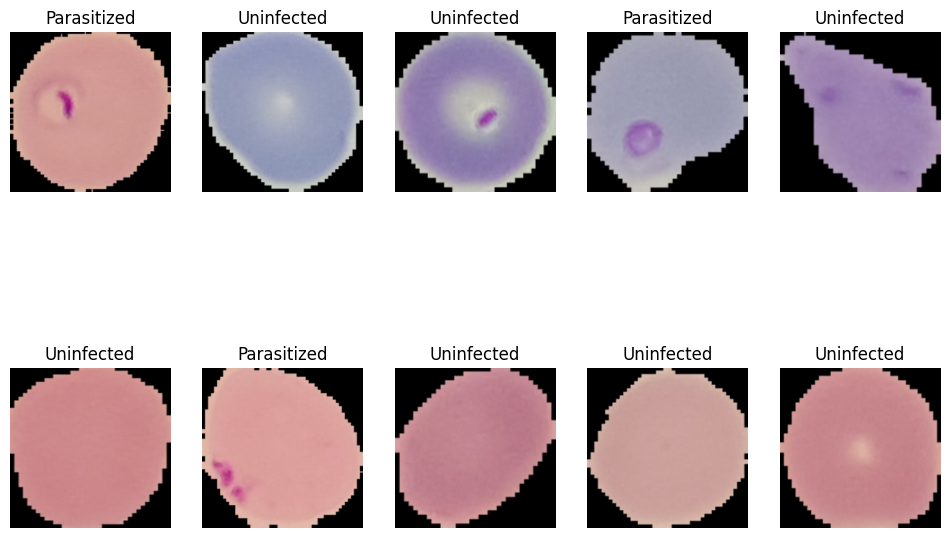

In [151]:
print("Original labels")
plt.figure(figsize = (12,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(sample_test_images[0][i])
  plt.title(mapped_real_labels[i])
  plt.axis("off")
plt.show()

Predicted labels


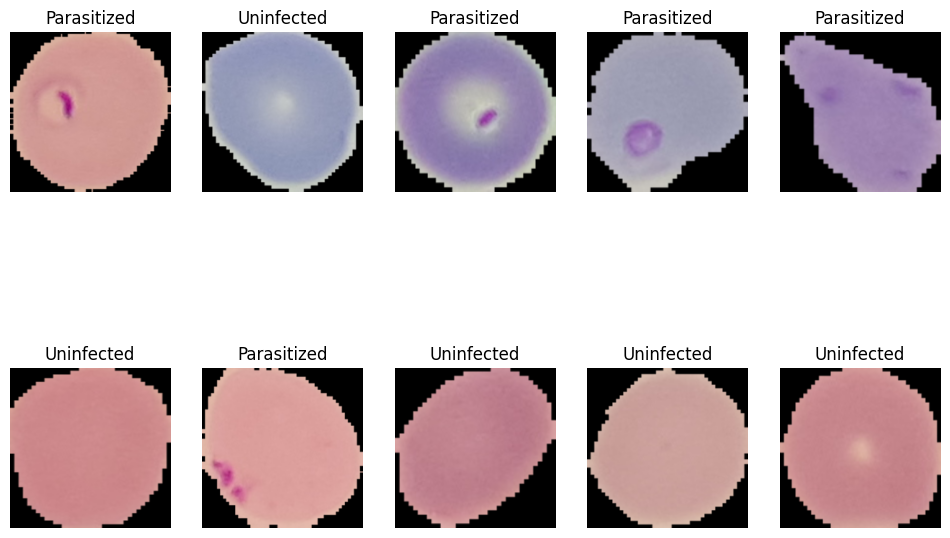

In [152]:
print("Predicted labels")
plt.figure(figsize = (12,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(sample_test_images[0][i])
  plt.title(mapped_predicted_labels[i])
  plt.axis("off")
plt.show()

# **Conclusion**

We had a good job.Our models's performance is not bad.Model is not overfitted/underfittet while training.